<a href="https://colab.research.google.com/github/Woongheelee7/Leon/blob/main/Liear_Regression_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from typing import List
from typing import Tuple
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from tqdm import tqdm

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

## Reading data

In [173]:
data = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/simple_linear_regression.csv",names=["firstcol","secondcol"])
data['thirdcol']=np.nan
data['thirdcol']=data['firstcol']*data['firstcol']
data.head()



,firstcol,secondcol,thirdcol
0,-15.000,-555.482,225.000000
1,-14.824,-388.301,219.750976
2,-14.648,-317.445,214.563904
3,-14.472,-412.942,209.438784
4,-14.296,-310.663,204.375616


## Exploratory Data Analysis (EDA)

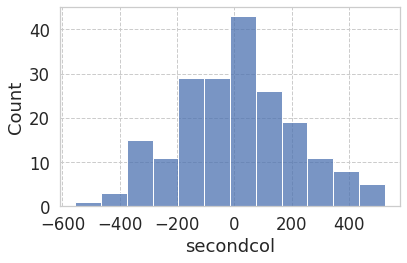

In [174]:
# distribution of the dependent variable
sns.histplot(x="secondcol", data=data)
plt.tight_layout()

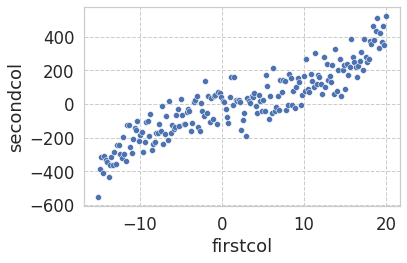

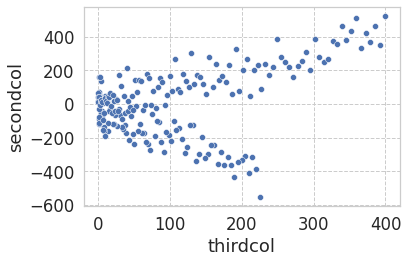

In [175]:
# correlations
continuous_variables = [
    "firstcol","thirdcol"
    
]

for variable in continuous_variables:
    plt.figure()
    sns.scatterplot(x=variable, y="secondcol", data=data)
    plt.tight_layout()

## Simple linear regression

beta_0 is: -35.3330
beta_1 is: 18.2241
R-square is: 0.8221


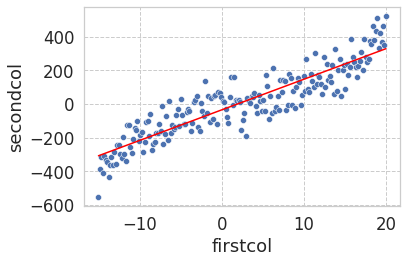

In [176]:


y = data["secondcol"]
x = data["firstcol"]

def simple_linear_regression(
    x: Union[List, np.ndarray, pd.Series], 
    y: Union[List, np.ndarray, pd.Series]) -> Tuple[float, float]:
    """Return the intercept and slope of a simple linear regression."""
    beta_1 = np.cov(x, y)[0][1] / np.cov(x, x)[0][1]
    beta_0 = np.mean(y) - beta_1 * np.mean(x)
    
    return beta_0, beta_1

beta_0, beta_1 = simple_linear_regression(x=x, y=y)

# calculate R^2
y_pred = beta_0 + beta_1 * x
SST = np.sum(np.square(y - np.mean(y)))
residual = y - y_pred
SSE = np.sum(np.square(residual))
r2 = 1 - SSE / SST

print(f"beta_0 is: {beta_0:5.4f}")
print(f"beta_1 is: {beta_1:5.4f}")
print(f"R-square is: {r2:5.4f}")

plt.figure()
x_range = np.linspace(start=np.min(x), stop=np.max(x), num=100)
sns.scatterplot(x="firstcol", y="secondcol", data=data)
sns.lineplot(x=x_range, y=(beta_0 + beta_1 * x_range), color="red")
plt.tight_layout()

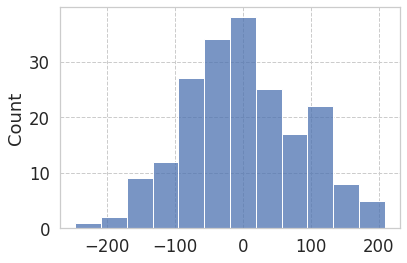

In [177]:
# residual analysis
plt.figure()
sns.histplot(residual)
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


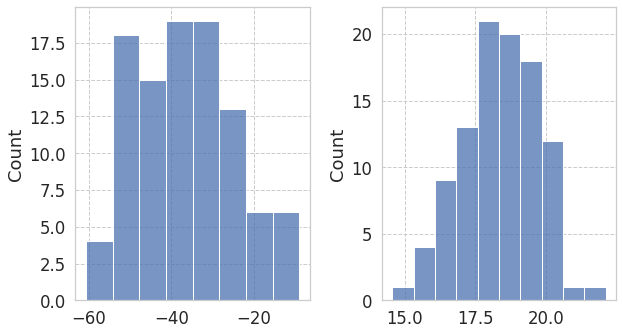

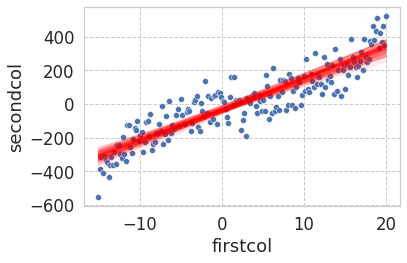

In [178]:
# accuracy of the coefficients
np.random.seed(42)
n_trials = 100

beta_0s, beta_1s = [], []
for _ in tqdm(range(n_trials)):
    sampling_proba = 0.2
    mask = np.random.choice([True, False], size=len(x), p=[sampling_proba, 1 - sampling_proba])
    x_sampled, y_sampled = x[mask], y[mask]
    beta_0, beta_1 = simple_linear_regression(x=x_sampled, y=y_sampled)
    beta_0s.append(beta_0)
    beta_1s.append(beta_1)

# plot the histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
sns.histplot(beta_0s, ax=axes[0])
sns.histplot(beta_1s, ax=axes[1])
plt.tight_layout()

# plot the fited lines
plt.figure()
x_range = np.linspace(start=np.min(x), stop=np.max(x), num=100)
for i in tqdm(range(len(beta_0s))):
    sns.lineplot(x=x_range, y=(beta_0s[i] + beta_1s[i] * x_range), color="red", alpha=0.1)
sns.scatterplot(x="firstcol", y="secondcol", data=data)
plt.tight_layout()

In [186]:
# confidence intervals
SE_beta_0 = (np.var(residual, ddof=2) * (1. / len(x) + (np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
SE_beta_1 = (np.var(residual,ddof=2) / np.sum((x - np.mean(x))**2))**0.5 

print(f"The standard error for beta_0 is: {SE_beta_0:5.4f}")
print(f"The standard error for beta_1 is: {SE_beta_1:5.4f}")

161.8138
The standard error for beta_0 is: 6.3000
The standard error for beta_1 is: 0.6024


In [180]:
# simple linear regression with the `statsmodels` library
model_1 = smf.ols(formula=' secondcol ~ firstcol',data=data)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:              secondcol   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     915.1
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           3.61e-76
Time:                        01:51:42   Log-Likelihood:                -1174.8
No. Observations:                 200   AIC:                             2354.
Df Residuals:                     198   BIC:                             2360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.3330      6.300     -5.608      0.0

In [188]:
# linear regress in matrix format
X = np.hstack(
    (np.ones(shape=(len(x), 1)), 
     x.to_numpy().reshape(-1, 1)))

# point estimate
beta_matrix = np.linalg.inv(X.T @ X) @ X.T @ y
print("The estimates for beta are:")
print(beta_matrix)

# variance
se_matrix = np.sqrt(np.var(residual, ddof=2) * np.linalg.inv(X.T @ X))
print("\nThe standard error for beta are:")
print(se_matrix)

LOW_pred_y = (beta_0+10*beta_1)-1.96*(np.var(residual, ddof=2) * (1. / len(x) + (10-np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
print(f"{LOW_pred_y:5.4f}")
UP_pred_y = (beta_0+10*beta_1)+1.96*(np.var(residual, ddof=2) * (1. / len(x) + (10-np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
print(f"{UP_pred_y:5.4f}")
LOW_pred_y2 = (-35.3330+10*18.2241)-1.96*(np.var(residual, ddof=2) * (1. / len(x) + (10-np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
print(f"{LOW_pred_y2:5.4f}")
UP_pred_y2 = (-35.3330+10*18.2241)+1.96*(np.var(residual, ddof=2) * (1. / len(x) + (10-np.mean(x))**2 / np.sum((x - np.mean(x))**2)))**0.5
print(f"{UP_pred_y2:5.4f}")

The estimates for beta are:
[-35.33303369  18.22408148]

The standard error for beta are:
[[6.29997242        nan]
 [       nan 0.60243669]]
141.8352
171.6468
132.0022
161.8138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


## Multi-variant linear regression

In [182]:
model_2 = smf.ols(formula='secondcol ~ firstcol + thirdcol', data=data)
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:              secondcol   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     455.4
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           1.33e-74
Time:                        01:51:42   Log-Likelihood:                -1174.8
No. Observations:                 200   AIC:                             2356.
Df Residuals:                     197   BIC:                             2365.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.0521      9.020     -4.108      0.0

In [183]:
# correlation between the continuous variables
data[continuous_variables].corr()

,firstcol,thirdcol
firstcol,1.000000,0.482286
thirdcol,0.482286,1.000000
